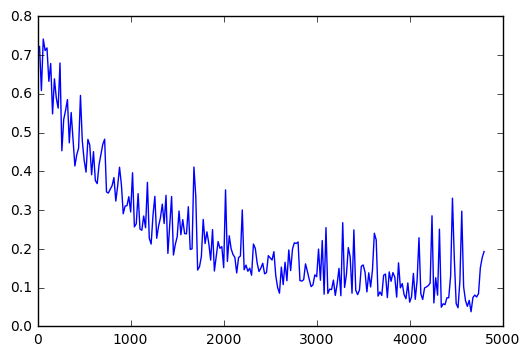

In [3]:
import matplotlib.pyplot as plt
import pickle

with open("training_history.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
plt.plot(b[0],b[1])
plt.show()

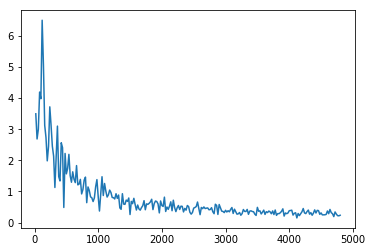

In [1]:
# p1b_aug2
import matplotlib.pyplot as plt
import pickle

with open("training_history.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
plt.plot(b[0],b[1])
plt.show()

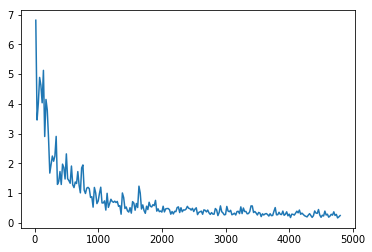

In [15]:
# p1b_aug3
import matplotlib.pyplot as plt
import pickle

with open("training_history.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
plt.plot(b[0],b[1])
plt.show()

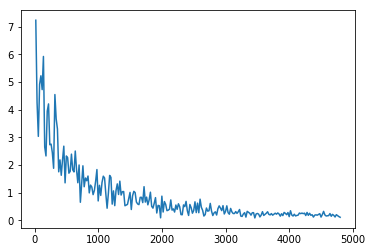

In [18]:
# p1b_aug4
import matplotlib.pyplot as plt
import pickle

with open("training_history.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
plt.plot(b[0],b[1])
plt.show()

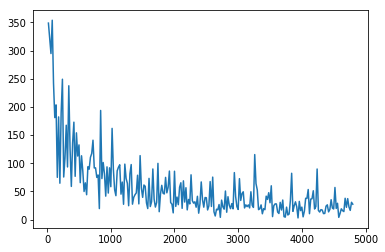

In [19]:
# p1b_aug5
import matplotlib.pyplot as plt
import pickle

with open("training_history.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
plt.plot(b[0],b[1])
plt.show()

In [1]:
import torch
import os
import cv2
import argparse
import torch.nn as nn
import random
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import pickle
from torch.autograd import Variable
from torch import optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Setting up configuration
configs = {"batch_train": 16, \
            "batch_test": 4, \
            "epochs": 40, \
            "num_workers": 4, \
            "learning_rate": 1e-6, \
            "data_augment": True, \
            "loss_margin": 1.5, \
            "decision_thresh": 0.90}

In [10]:
# Define dataset class
class FaceDateSet(Dataset):
    """lfw face data set."""

    def __init__(self, root_dir, split_file, transform = None, augment = False):
        self.root_dir = root_dir
        self.split_file = split_file
        self.transform = transform
        self.img_paths = self.parse_files()
        self.augment = augment

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Get items from path here
        img1_path = os.path.join(self.root_dir, self.img_paths[idx][0])
        img2_path = os.path.join(self.root_dir, self.img_paths[idx][1])
        img_label = map(float,self.img_paths[idx][2])
        img_label = torch.from_numpy(np.array(img_label)).float()
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        img1 = img1.convert('RGB')
        img2 = img2.convert('RGB')
        print "img1_path:", img1_path

        isaugment = (random.random() <= 0.5)
        if self.augment == True and isaugment == True:
            isflip = (random.random() <= 0.7)
            if isflip == True:
                print "flipped"
                img1 = img1.transpose(Image.FLIP_LEFT_RIGHT)
            isscale = (random.random() <= 0.7)
            if isscale == True:
                ratio = 0.6*random.random() + 0.7
                print "scaled, ratio:", ratio
                if ratio > 1:
                    old_size = img1.size
                    new_size = tuple([int(i*ratio) for i in img1.size])
                    img1 = img1.resize(new_size, Image.ANTIALIAS)
                    left = abs((old_size[0] - new_size[0])/2)
                    top = abs((old_size[1] - new_size[1])/2)
                    right = abs((old_size[0] + new_size[0])/2)
                    bottom = abs((old_size[1] + new_size[1])/2)
                    img1 = img1.crop((left,top,right,bottom))
                else:
                    old_size = img1.size
                    new_size = tuple([int(i*ratio) for i in img1.size])
                    img1 = img1.resize(new_size, Image.ANTIALIAS)
                    left = 0
                    top = 0
                    right = old_size[0]
                    bottom = old_size[1]
                    img1 = img1.crop((left,top,right,bottom))
            istrans = (random.random() <= 0.7)
            if istrans == True:
                translate_x = int(10 - random.random()*20)
                translate_y = int(10 - random.random()*20)
                print "translated, (x,y): ", translate_x, translate_y
                img1 = img1.transform(img1.size, Image.AFFINE, (1,0,translate_x,0,1,translate_y))
            isrotate = (random.random() <= 0.7)
            if isrotate == True:
                angle = 30 - 60*random.random()
                print "rotated, angle:", angle
                img1 = img1.rotate(angle)

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        sample = {'img1': img1, 'img2': img2, 'label': img_label}
        return sample

    def parse_files(self):
        img_paths = []
        with open(self.split_file) as f:
            img_paths = f.readlines()
        img_paths = [x.split() for x in img_paths]
        return img_paths

In [7]:
# Define deep neural network
class SiameseNet(nn.Module):

    def __init__(self):
        super(SiameseNet, self).__init__()
        self.nn1 = nn.Sequential(
            nn.Conv2d(3,64,5,padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(64,128,5,padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(128,256,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(256,512,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )

        self.nn2 = nn.Sequential(
            nn.Linear(131072,1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Linear(1024,50)
        )

    def net_forward(self,x):
        temp = self.nn1(x)
        temp = temp.view(temp.size()[0], -1)
        output = self.nn2(temp)
        return output

    def forward(self,x1,x2):
        output1 = self.net_forward(x1)
        output2 = self.net_forward(x2)
        return output1, output2


In [6]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin = 1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        d = F.pairwise_distance(output1, output2)
        loss = torch.mean((label) * torch.pow(d,2) +(1-label) * torch.pow(torch.clamp(self.margin - d, min=0.0), 2))
        return loss

In [11]:
# Training process setup
data_trans = transforms.Compose([transforms.Scale((128,128)),transforms.ToTensor()])
face_train = FaceDateSet(root_dir='lfw', split_file='train.txt', transform=data_trans, augment=configs['data_augment'])
train_loader = DataLoader(face_train, batch_size=configs['batch_train'], shuffle=True, num_workers=configs['num_workers'])

In [12]:
iterrr = iter(train_loader)
sampleimg = next(iterrr)['img1']
print type(sampleimg)

img1_path: lfw/Olesya_Bonabarenko/Olesya_Bonabarenko_0001.jpg
img1_path: lfw/Eric_Christian_Olsen/Eric_Christian_Olsen_0001.jpg
img1_path: lfw/Justin_Wilson/Justin_Wilson_0001.jpg
flipped
rotated, angle: -8.02136736689
flipped
scaled, ratio: 1.0882889551
rotated, angle: 2.58982108274
img1_path: lfw/Matt_Damon/Matt_Damon_0002.jpg
scaled, ratio: 0.755035771526
translated, (x,y):  8 0
rotated, angle: -19.0880552891
img1_path: lfw/David_Hilt/David_Hilt_0001.jpg
img1_path: lfw/Brian_Pavlich/Brian_Pavlich_0001.jpg
flipped
scaled, ratio: 0.910706744571
translated, (x,y):  -6 -8
rotated, angle: -17.0828496582
img1_path: lfw/Geoffrey_Rush/Geoffrey_Rush_0001.jpg
flipped
scaled, ratio: 0.747524048242
translated, (x,y):  1 0
rotated, angle: -15.7348396713
img1_path: lfw/Angel_Maza/Angel_Maza_0001.jpg
flipped
scaled, ratio: 0.841303034924
rotated, angle: 26.0813561754
img1_path: lfw/Andy_Roddick/Andy_Roddick_0012.jpg
scaled, ratio: 0.972968160168
img1_path: lfw/Ricardo_Monasterio/Ricardo_Monasterio

rotated, angle: -20.2921807245
img1_path: lfw/Sebastien_Grosjean/Sebastien_Grosjean_0001.jpg
flipped
scaled, ratio: 0.96343089447
translated, (x,y):  9 -5
rotated, angle: -23.1839249195
img1_path: lfw/Oxana_Fedorova/Oxana_Fedorova_0002.jpg
flipped
scaled, ratio: 1.27892812783
rotated, angle: 22.1684077445
img1_path: lfw/Jean_Chretien/Jean_Chretien_0031.jpg
flipped
scaled, ratio: 1.02415092253
rotated, angle: 7.92315783169
img1_path: lfw/Julio_Iglesias_Jr/Julio_Iglesias_Jr_0001.jpg
img1_path: lfw/Yasar_Yakis/Yasar_Yakis_0003.jpg
flipped
img1_path: lfw/Martin_Scorsese/Martin_Scorsese_0004.jpg
flipped
scaled, ratio: 1.15308667082
img1_path: lfw/Queen_Elizabeth_II/Queen_Elizabeth_II_0006.jpg
rotated, angle: -1.25929766383
flipped
scaled, ratio: 0.914666237244
translated, (x,y):  -2 2
rotated, angle: -3.37864899475
rotated, angle: 28.7226751098
img1_path: lfw/Guillaume_Soro/Guillaume_Soro_0001.jpg
img1_path: lfw/Henry_Hyde/Henry_Hyde_0001.jpg
img1_path: lfw/John_Lithgow/John_Lithgow_0001.jp

In [13]:
def imshow(img,text=False,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

In [17]:
%matplotlib qt 
imshow(utils.make_grid(sampleimg))

ImportError: Matplotlib qt-based backends require an external PyQt4, PyQt5,
PySide or PySide2 package to be installed, but it was not found.

(16, 3, 128, 128)


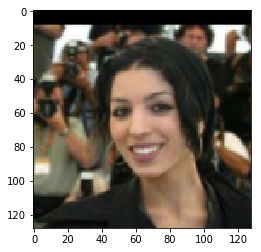

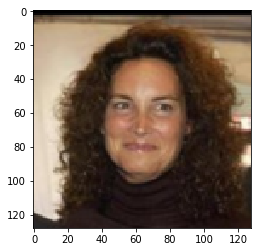

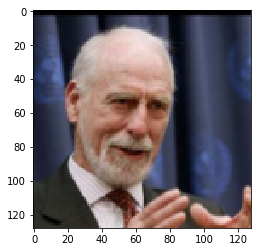

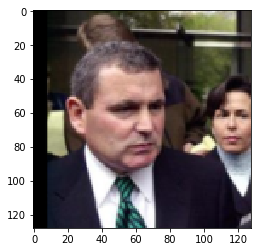

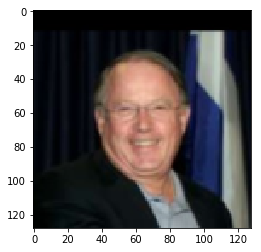

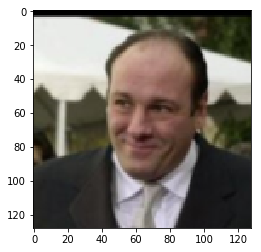

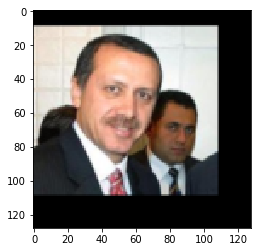

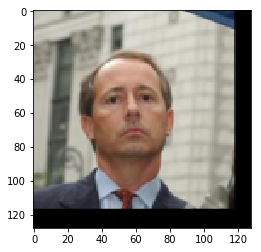

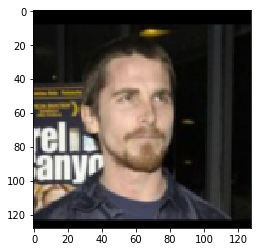

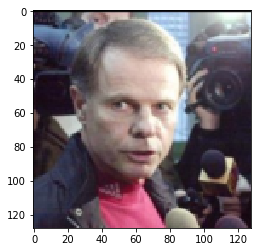

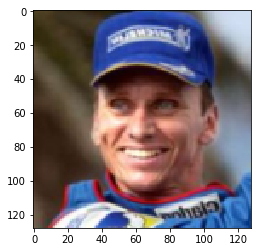

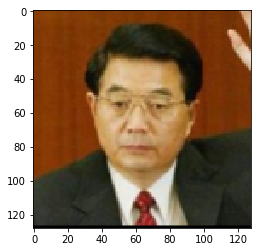

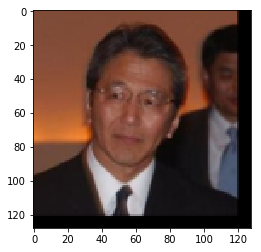

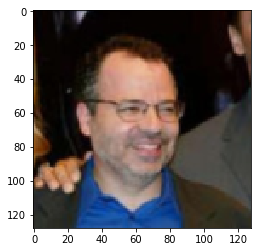

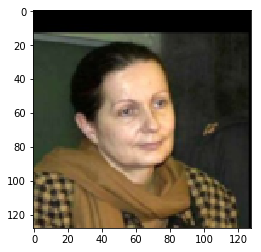

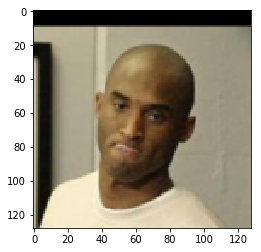

In [29]:
sampleimg = sampleimg.numpy()
print sampleimg.shape
for i in range(sampleimg.shape[0]):
    sampleone = sampleimg[i]
    plt.imshow(np.transpose(sampleone, (1,2,0)))
    plt.show()

In [ ]:
weights_dir = './model_best_contr_aug3.pth.tar'
# Training the net
net = SiameseNet().cuda()
optimizer = optim.Adam(net.parameters(), lr = configs['learning_rate'])
loss_fn = ContrastiveLoss(margin = configs['loss_margin'])
total_epoch = configs['epochs']
counter = []
loss_history = []
iteration = 0 
for epoch in range(total_epoch):
    for batch_idx, batch_sample in enumerate(train_loader):
        img1 = batch_sample['img1']
        img2 = batch_sample['img2']
        label = batch_sample['label']
        img1, img2, y = Variable(img1).cuda(), Variable(img2).cuda(), Variable(label).cuda()
        optimizer.zero_grad()
        feature1, feature2 = net(img1, img2)
        contr_loss = loss_fn(feature1, feature2, y)
        contr_loss.backward()
        optimizer.step()

        if batch_idx % (len(face_train)/configs['batch_train']/5) == 0:
            print "Epoch %d, Batch %d Loss %f" % (epoch, batch_idx, contr_loss.data[0])
            iteration += 20
            counter.append(iteration)
            loss_history.append(contr_loss.data[0])

# Save the trained network
torch.save(net.state_dict(), weights_dir)
total_hist = [counter, loss_history]
with open("training_history.txt", "wb") as fp:
    pickle.dump(total_hist, fp)

In [6]:
weights_dir = './model_best2.pth.tar'
net = SiameseNet().cuda()
net.load_state_dict(torch.load(weights_dir))
loss_fn = nn.BCELoss()

# Testing on the training data
data_trans1 = transforms.Compose([transforms.Scale((128,128)),transforms.ToTensor()])
face_test1 = FaceDateSet(root_dir='lfw', split_file='train.txt', transform = data_trans1)
test1_loader = DataLoader(face_test1, batch_size=4, shuffle=False)
total_loss = 0.0
total_correct = 0

for batch_idx, batch_sample in enumerate(test1_loader):
    img1 = batch_sample['img1']
    img2 = batch_sample['img2']
    label = batch_sample['label']
    img1, img2, y = Variable(img1, volatile=True).cuda(), Variable(img2, volatile=True).cuda(), Variable(label,volatile=True).cuda()
    y_pred = net(img1, img2)
    bce_loss = loss_fn(y_pred, y)
    y_pred_round = torch.round(y_pred)
    if batch_idx % int(len(face_test1)/20) == 0:
        print "Batch %d Loss %f" % (batch_idx, bce_loss.data[0])
    total_loss += bce_loss.data[0]
    total_correct += (y_pred_round.view(-1) == y.view(-1)).sum().float()
    
mean_loss = total_loss / (float(len(face_test1)) / 4.0) 
mean_correct = total_correct / float(len(face_test1))
print "Average BCE loss on training data is: ", mean_loss, "\n Prediction accuracy is: ", mean_correct


Batch 0 Loss 0.090949
Batch 110 Loss 0.725484
Batch 220 Loss 0.017345
Batch 330 Loss 0.699157
Batch 440 Loss 0.026592
Average BCE loss on training data is:  0.155582274041 
 Prediction accuracy is:  Variable containing:
 0.9377
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [7]:
weights_dir = './model_best2.pth.tar'
net = SiameseNet().cuda()
net.load_state_dict(torch.load(weights_dir))
loss_fn = nn.BCELoss()

# Testing on the training data
data_trans2 = transforms.Compose([transforms.Scale((128,128)),transforms.ToTensor()])
face_test2 = FaceDateSet(root_dir='lfw', split_file='test.txt', transform = data_trans2)
test2_loader = DataLoader(face_test2, batch_size=4, shuffle=False)
total_loss = 0.0
total_correct = 0

for batch_idx, batch_sample in enumerate(test2_loader):
    img1 = batch_sample['img1']
    img2 = batch_sample['img2']
    label = batch_sample['label']
    img1, img2, y = Variable(img1, volatile=True).cuda(), Variable(img2, volatile=True).cuda(), Variable(label,volatile=True).cuda()
    y_pred = net(img1, img2)
    bce_loss = loss_fn(y_pred, y)
    y_pred_round = torch.round(y_pred)
    if batch_idx % int(len(face_test2)/20) == 0:
        print "Batch %d Loss %f" % (batch_idx, bce_loss.data[0])
    total_loss += bce_loss.data[0]
    total_correct += (y_pred_round.view(-1) == y.view(-1)).sum().float()
    
mean_loss = total_loss / (float(len(face_test2)) / 4.0) 
mean_correct = total_correct / float(len(face_test2))
print "Average BCE loss on test data is: ", mean_loss, "\n Prediction accuracy is: ", mean_correct

Batch 0 Loss 0.463303
Batch 50 Loss 1.497920
Batch 100 Loss 0.668122
Batch 150 Loss 0.680550
Batch 200 Loss 0.763543
Average BCE loss on test data is:  0.79564036119 
 Prediction accuracy is:  Variable containing:
 0.5120
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [13]:
data_trans = transforms.Compose([transforms.Scale((128,128)),transforms.ToTensor()])
face_train = FaceDateSet(root_dir='lfw', split_file='train.txt',transform = data_trans)
train_loader = DataLoader(face_train, batch_size=8, shuffle=True, num_workers=4)

In [14]:
iterrr = iter(train_loader)
print next(iterrr)
# print face_train[0]

{'img2': 
( 0 , 0 ,.,.) = 
  0.9333  0.9255  0.9216  ...   0.9490  0.9490  0.9451
  0.9137  0.9294  0.9216  ...   0.9490  0.9451  0.9412
  0.8627  0.9333  0.9373  ...   0.9529  0.9490  0.9490
           ...             ⋱             ...          
  0.4784  0.5098  0.5176  ...   0.5255  0.5333  0.5137
  0.3961  0.4549  0.4745  ...   0.5569  0.5333  0.4627
  0.4196  0.4392  0.4745  ...   0.6157  0.5255  0.4431

( 0 , 1 ,.,.) = 
  0.9412  0.9333  0.9294  ...   0.9529  0.9529  0.9490
  0.9216  0.9373  0.9294  ...   0.9529  0.9490  0.9451
  0.8706  0.9412  0.9451  ...   0.9569  0.9529  0.9529
           ...             ⋱             ...          
  0.5098  0.5373  0.5373  ...   0.5412  0.5490  0.5333
  0.4392  0.4941  0.5020  ...   0.5725  0.5490  0.4863
  0.4706  0.4824  0.5059  ...   0.6314  0.5451  0.4667

( 0 , 2 ,.,.) = 
  0.9216  0.9137  0.9098  ...   0.9333  0.9333  0.9294
  0.9020  0.9176  0.9059  ...   0.9333  0.9294  0.9255
  0.8510  0.9216  0.9216  ...   0.9451  0.9333  0.9333
  

In [ ]:
# Training the net
net = SiameseNet()
optimizer = optim.Adam(net.parameters(), lr = 1e-6)
loss_fn = nn.BCELoss()
total_epoch = 30 
for epoch in range(total_epoch):
    for batch_idx, batch_sample in enumerate(train_loader):
        img1 = batch_sample['img1']
        img2 = batch_sample['img2']
        label = batch_sample['label']
        # label = label.view(label.numel(),-1)
        img1, img2, y = Variable(img1), Variable(img2), Variable(label)
        optimizer.zero_grad()
        y_pred = net(img1, img2)
        bce_loss = loss_fn(y_pred, y)
        bce_loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print "Epoch %d, Batch %d Loss %f" % (epoch, batch_idx, bce_loss.data[0])

Epoch 0, Batch 0 Loss 0.569435


In [8]:
net = SiameseNet()
optimizer = optim.Adam(net.parameters(), lr = 1e-6)
loss_fn = nn.BCELoss()
total_epoch = 2
for epoch in range(total_epoch):
    for batch_idx, batch_sample in enumerate(train_loader):
        img1 = batch_sample['img1']
        img2 = batch_sample['img2']
        label = batch_sample['label'].float()
        label = label.view(label.numel(),-1)
        img1, img2, y = Variable(img1), Variable(img2), Variable(label)
        optimizer.zero_grad()
        y_pred = net(img1, img2)
        bce_loss = loss_fn(y_pred, y)
        bce_loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print "Epoch %d, Batch %d Loss %f" % (epoch, batch_idx, bce_loss.data[0])

Epoch 0, Batch 0 Loss 0.692584


Process Process-9:
Process Process-10:
Process Process-12:
Process Process-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 34, i

KeyboardInterrupt: 

In [4]:
x = Variable(torch.ones(2,2),requires_grad=True)
print(x)
y = x+2
print(y)
print(y.grad_fn)
z = y*y*3
out = z.mean()
print(z,out)
out.backward()
print(x.grad)

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]

Variable containing:
 3  3
 3  3
[torch.FloatTensor of size 2x2]

Variable containing:
 27  27
 27  27
[torch.FloatTensor of size 2x2]
 Variable containing:
 27
[torch.FloatTensor of size 1]

Variable containing:
 4.5000  4.5000
 4.5000  4.5000
[torch.FloatTensor of size 2x2]



In [4]:
weights_dir = "./model_best.pth.tar"
net = SiameseNet()
net.load_state_dict(torch.load(weights_dir))
loss_fn = nn.BCELoss()

# Testing on the training data
data_trans1 = transforms.Compose([transforms.ToPILImage(),transforms.Scale((128,128)),transforms.ToTensor()])
face_test1 = FaceDateSet(root_dir='lfw', split_file='train.txt', transform = data_trans1)
test1_loader = DataLoader(face_test1, batch_size=1, shuffle=False)
total_loss = 0.0
for batch_idx, batch_sample in enumerate(test1_loader):
    img1 = batch_sample['img1']
    img2 = batch_sample['img2']
    label = batch_sample['label'].float()
    label = label.view(label.numel(),-1)
    img1, img2, y = Variable(img1), Variable(img2), Variable(label)
    y_pred = net(img1, img2)
    bce_loss = loss_fn(y_pred, y)
    if batch_idx % int(len(face_test1)/10) == 0:
        print "Batch %d Loss %f" % (batch_idx, bce_loss.data[0])
    total_loss += bce_loss.data[0]
mean_loss = total_loss / float(len(face_test1))
print "Average BCE loss on training data is: ", mean_loss

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [3]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)


1.00000e-06 *
  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000
  0.0000  3.3438  0.0000
  3.2986  0.0000  0.0000
[torch.FloatTensor of size 5x3]



In [6]:
x.add_(x)
print(x)


1.00000e-06 *
  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000
  0.0000  6.6877  0.0000
  6.5972  0.0000  0.0000
[torch.FloatTensor of size 5x3]



In [9]:
b = x.numpy()
print(b)

[[  5.31873886e-37   0.00000000e+00   5.07241471e-12]
 [  9.16112884e-41   4.90654739e-12   9.16112884e-41]
 [  2.37309200e-37   0.00000000e+00   2.37310276e-37]
 [  0.00000000e+00   6.68766006e-06   9.16112884e-41]
 [  6.59719444e-06   9.16112884e-41   5.06125003e-12]]


In [11]:
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a,1,out=a)
print(a)
print(b)

[ 2.  2.  2.  2.  2.]

 2
 2
 2
 2
 2
[torch.DoubleTensor of size 5]

